In [1]:
!nproc & nvidia-smi -L

20
GPU 0: NVIDIA GeForce RTX 3060 (UUID: GPU-125eaf29-537f-5e5a-8a00-140ef5b42572)


In [24]:
import os
import sys
import uuid
import json
import random
import hashlib
import pandas as pd
import numpy as np
import networkx as nx
import ipyplot as iplt
from tqdm.notebook import tqdm

base_url = "https://aisle-3-image-test.s3.eu-west-2.amazonaws.com/"
images_dir = "/data/"

from dotenv import load_dotenv; load_dotenv()
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


## Load processed data

In [3]:
df = pd.read_csv("s3://aisle3-ml-datasets/arcface/main.csv")
df

,id,variant_id,title,merchant,brand,gender,color,image,pose
0,allsole.10491511,allsole.10491633,Vans Authentic Canvas Trainers,allsole,vans,unisex,Black,feed_offers/allsole/allsole.10491511/c24370ba-...,side_shot
1,allsole.10491511,allsole.10491633,Vans Authentic Canvas Trainers,allsole,vans,unisex,Black,feed_offers/allsole/allsole.10491511/09c51b1d-...,side_shot
2,allsole.10491511,allsole.10491633,Vans Authentic Canvas Trainers,allsole,vans,unisex,Black,feed_offers/allsole/allsole.10491511/39b9a4dd-...,side_shot
3,allsole.10491511,allsole.10491633,Vans Authentic Canvas Trainers,allsole,vans,unisex,Black,feed_offers/allsole/allsole.10491511/395bb382-...,upper_shot
4,allsole.10491511,allsole.10491633,Vans Authentic Canvas Trainers,allsole,vans,unisex,Black,feed_offers/allsole/allsole.10491511/49a7919e-...,heel_shot
...,...,...,...,...,...,...,...,...,...
194939,ssense.221903M237019,ssense.221903M237019,Coach 1941 Black & Tan Logo Slide Sandals,ssense,coach,men,Tan signature,feed_offers/ssense/ssense.221903M237019/e89ab4...,pair_shot
194940,ssense.221903M237019,ssense.221903M237019,Coach 1941 Black & Tan Logo Slide Sandals,ssense,coach,men,Tan signature,feed_offers/ssense/ssense.221903M237019/7a87f5...,partial_shot
194941,ssense.221903M237020,ssense.221903M237020,Coach 1941 Black & Grey Logo Slide Sandals,ssense,coach,men,Charcoal signature,feed_offers/ssense/ssense.221903M237020/7eee9e...,pair_shot
194942,ssense.221903M237021,ssense.221903M237021,Coach 1941 Black & Off-White Logo Slide Sandals,ssense,coach,men,Chalk black,feed_offers/ssense/ssense.221903M237021/efcef4...,pair_shot


In [5]:
%%sql result <<
SELECT * FROM gold_annotations

926 rows affected.
Returning data to local variable result


In [6]:
# matched_df = pd.read_csv("s3://aisle3-ml-datasets/arcface/gold_matches.csv")
matched_df = result.DataFrame()
matched_df = matched_df[matched_df.source.isin(set(df.id)) & matched_df.target.isin(set(df.id))]
matched_df

,id,source,target,match,timestamp
0,1982,allsole.10651208,jdsports.1267728,1,0000-00-00 00:00:00
1,1983,allsole.10651208,bluetomato.466560,1,0000-00-00 00:00:00
2,1984,allsole.10651215,bluetomato.113325,1,0000-00-00 00:00:00
3,1985,schuh.3300031260,footlocker.315550477202,1,0000-00-00 00:00:00
4,1986,schuh.3410771020,allsole.12971567,1,0000-00-00 00:00:00
...,...,...,...,...,...
921,2903,allsole.11959616,schuh.1793037260,1,0000-00-00 00:00:00
922,2904,footasylum.37187001,asos.102383544,1,0000-00-00 00:00:00
923,2905,asos.2031681,allsole.13187164,1,0000-00-00 00:00:00
924,2906,footasylum.CD3476104,asos.1960779,1,0000-00-00 00:00:00


In [7]:
G = nx.Graph()
# first populate the graph with the all nodes no edges
for node in set(matched_df.source) | set(matched_df.target):
    G.add_node(node)

# connect all positive edges
for i, row in matched_df.iterrows():
    if row.match == 1:
        G.add_edge(row.source, row.target)

# all orphans will be clusters of single offer
print(G.number_of_nodes(), G.number_of_edges())

533 316


In [8]:
clusters = sorted(list(nx.connected_components(G)), key=len, reverse=True)
pd.Series(clusters).apply(len).value_counts()

2    201
3     24
4     11
9      1
6      1
dtype: int64

In [10]:
try:
    images = (base_url + df[df.id.isin(clusters[i])]).image.values.tolist()
    random.shuffle(images)
    iplt.plot_images(
        images,
        max_images=len(images),
        show_url=False,
    )
    i += 1
except (NameError, IndexError):
    i = 0
    print("Run this cell again to iterate through clusters")

In [11]:
df.set_index("id", drop=False, inplace=True)
df = df.loc[set.union(*clusters)]
df

,id,variant_id,title,merchant,brand,gender,color,image,pose
id,,,,,,,,,
schuh.1700709970,schuh.1700709970,schuh.1700709970,Palladium Multi Outdoorsy Urbanity Sandals,schuh,palladium,women,Multicolour,feed_offers/schuh/schuh.1700709970/64e9d74d-d0...,side_shot
schuh.1700709970,schuh.1700709970,schuh.1700709970,Palladium Multi Outdoorsy Urbanity Sandals,schuh,palladium,women,Multicolour,feed_offers/schuh/schuh.1700709970/42bbce4f-d1...,pair_shot
schuh.1700709970,schuh.1700709970,schuh.1700709970,Palladium Multi Outdoorsy Urbanity Sandals,schuh,palladium,women,Multicolour,feed_offers/schuh/schuh.1700709970/848e6cee-ce...,side_shot
schuh.1700709970,schuh.1700709970,schuh.1700709970,Palladium Multi Outdoorsy Urbanity Sandals,schuh,palladium,women,Multicolour,feed_offers/schuh/schuh.1700709970/081fdd7f-d9...,heel_shot
allsole.13152779,allsole.13152779,allsole.13152772,UGG Oh Fluffita Sheepskin Slippers,allsole,ugg,women,Pink,feed_offers/allsole/allsole.13152779/b8cd86cc-...,side_shot
...,...,...,...,...,...,...,...,...,...
allsole.12971520,allsole.12971520,allsole.12971520,Converse Chuck Taylor All Star Cx Create Next ...,allsole,converse,men,White,feed_offers/allsole/allsole.12971520/3225ec5d-...,side_shot
allsole.12971520,allsole.12971520,allsole.12971520,Converse Chuck Taylor All Star Cx Create Next ...,allsole,converse,men,White,feed_offers/allsole/allsole.12971520/5ec40753-...,pair_shot
allsole.12971520,allsole.12971520,allsole.12971520,Converse Chuck Taylor All Star Cx Create Next ...,allsole,converse,men,White,feed_offers/allsole/allsole.12971520/eaaa497f-...,pair_shot


<AxesSubplot:>

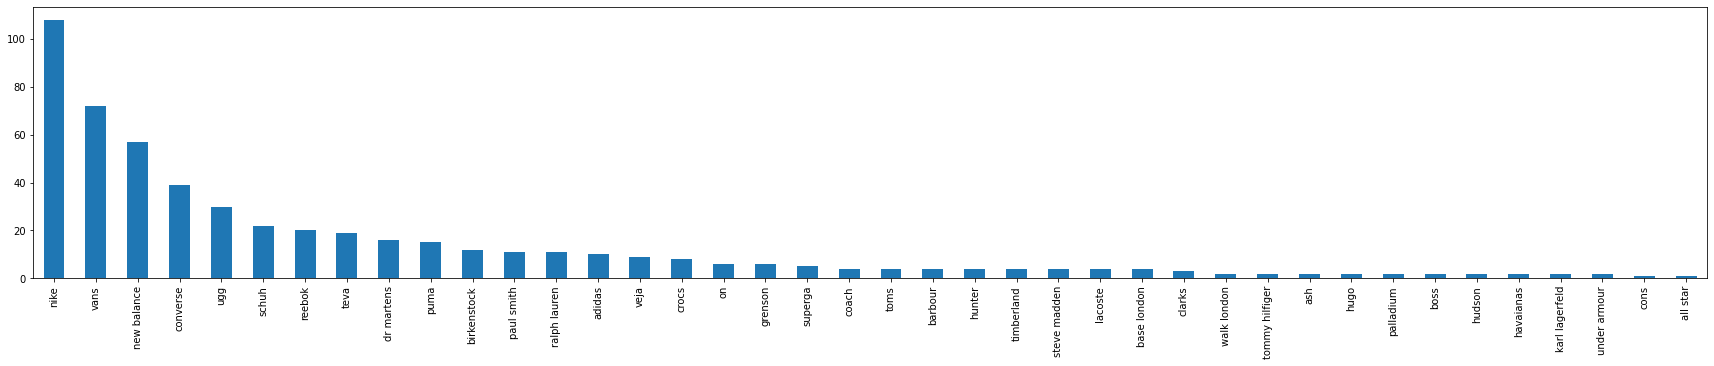

In [12]:
df.drop_duplicates("id").brand.value_counts().plot.bar(figsize=(30,5))

<AxesSubplot:>

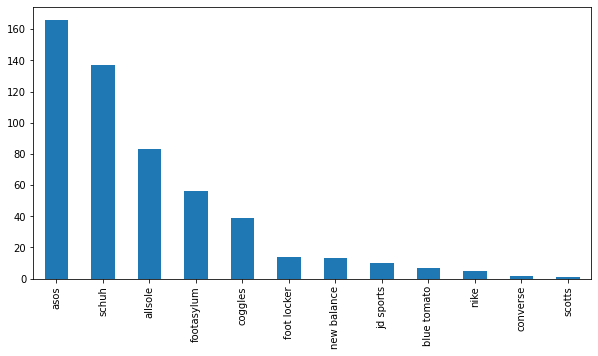

In [13]:
df.drop_duplicates("id").merchant.value_counts().plot.bar(figsize=(10,5))

In [14]:
df["label"] = None
for i, cluster in enumerate(clusters):
    df.loc[cluster, "label"] = i
df = df.reset_index(drop=True)
df

,id,variant_id,title,merchant,brand,gender,color,image,pose,label
0,schuh.1700709970,schuh.1700709970,Palladium Multi Outdoorsy Urbanity Sandals,schuh,palladium,women,Multicolour,feed_offers/schuh/schuh.1700709970/64e9d74d-d0...,side_shot,223
1,schuh.1700709970,schuh.1700709970,Palladium Multi Outdoorsy Urbanity Sandals,schuh,palladium,women,Multicolour,feed_offers/schuh/schuh.1700709970/42bbce4f-d1...,pair_shot,223
2,schuh.1700709970,schuh.1700709970,Palladium Multi Outdoorsy Urbanity Sandals,schuh,palladium,women,Multicolour,feed_offers/schuh/schuh.1700709970/848e6cee-ce...,side_shot,223
3,schuh.1700709970,schuh.1700709970,Palladium Multi Outdoorsy Urbanity Sandals,schuh,palladium,women,Multicolour,feed_offers/schuh/schuh.1700709970/081fdd7f-d9...,heel_shot,223
4,allsole.13152779,allsole.13152772,UGG Oh Fluffita Sheepskin Slippers,allsole,ugg,women,Pink,feed_offers/allsole/allsole.13152779/b8cd86cc-...,side_shot,37
...,...,...,...,...,...,...,...,...,...,...
2301,allsole.12971520,allsole.12971520,Converse Chuck Taylor All Star Cx Create Next ...,allsole,converse,men,White,feed_offers/allsole/allsole.12971520/3225ec5d-...,side_shot,49
2302,allsole.12971520,allsole.12971520,Converse Chuck Taylor All Star Cx Create Next ...,allsole,converse,men,White,feed_offers/allsole/allsole.12971520/5ec40753-...,pair_shot,49
2303,allsole.12971520,allsole.12971520,Converse Chuck Taylor All Star Cx Create Next ...,allsole,converse,men,White,feed_offers/allsole/allsole.12971520/eaaa497f-...,pair_shot,49
2304,allsole.12971520,allsole.12971520,Converse Chuck Taylor All Star Cx Create Next ...,allsole,converse,men,White,feed_offers/allsole/allsole.12971520/1767e12f-...,pair_shot,49


In [15]:
df.isna().value_counts()

id     variant_id  title  merchant  brand  gender  color  image  pose   label
False  False       False  False     False  False   False  False  False  False    2306
dtype: int64

In [17]:
import hashlib
from tqdm.contrib.concurrent import process_map, thread_map

def md5_hash(file):
    hash_md5 = hashlib.md5()
    with open(file, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

df["md5"] =  pd.Series(
    thread_map(
        md5_hash,
        df.image.apply(lambda img: os.path.join(images_dir, img)),
        max_workers=16,
        chunksize=100
    )
)

  0%|          | 0/2306 [00:00<?, ?it/s]

In [19]:
df.md5.value_counts().value_counts()

1    2279
2      12
3       1
Name: md5, dtype: int64

In [28]:
out_path_prefix = "pm-test/images/"
# df["img_tmp"] = df.image.copy()
df.image =  out_path_prefix + df.md5
df.image

0       pm-test/images/f376b369fdf4e87a2438bc5e1fd18c64
1       pm-test/images/8a6e767e4368b335fbc2e2789d773a63
2       pm-test/images/a38d3741a1d0070530827c26d9fe6efa
3       pm-test/images/64da1614dd6980da393489d971efddcd
4       pm-test/images/411d2046ef0a3b615494215528609213
                             ...                       
2301    pm-test/images/92f7611da197e6a3e954191038b0ba45
2302    pm-test/images/cde99191722da42383be4d8ae2a9831c
2303    pm-test/images/f789d55497491b2eb9a58a09da1983a9
2304    pm-test/images/a0c4fe59472b54669a38c5dee04b575d
2305    pm-test/images/6e660c36c338869cb05a68600b837be7
Name: image, Length: 2306, dtype: object

In [29]:
import shutil

shutil.rmtree(os.path.join(images_dir, out_path_prefix), ignore_errors=True)

for img_from, img_to in tqdm(zip(df.img_tmp, df.image), total=len(df)):
    img_from = os.path.join(images_dir, img_from)
    img_to = os.path.join(images_dir, img_to)
    os.makedirs(os.path.dirname(img_to), exist_ok=True)
    shutil.copyfile(img_from, img_to)

  0%|          | 0/2306 [00:00<?, ?it/s]

In [ ]:
!aws s3 sync $images_dir$out_path_prefix s3://aisle3-ml-datasets/$out_path_prefix --quiet

In [31]:
df.drop(columns=["img_tmp", "md5"], inplace=True)
df

,id,variant_id,title,merchant,brand,gender,color,image,pose,label
0,schuh.1700709970,schuh.1700709970,Palladium Multi Outdoorsy Urbanity Sandals,schuh,palladium,women,Multicolour,pm-test/images/f376b369fdf4e87a2438bc5e1fd18c64,side_shot,223
1,schuh.1700709970,schuh.1700709970,Palladium Multi Outdoorsy Urbanity Sandals,schuh,palladium,women,Multicolour,pm-test/images/8a6e767e4368b335fbc2e2789d773a63,pair_shot,223
2,schuh.1700709970,schuh.1700709970,Palladium Multi Outdoorsy Urbanity Sandals,schuh,palladium,women,Multicolour,pm-test/images/a38d3741a1d0070530827c26d9fe6efa,side_shot,223
3,schuh.1700709970,schuh.1700709970,Palladium Multi Outdoorsy Urbanity Sandals,schuh,palladium,women,Multicolour,pm-test/images/64da1614dd6980da393489d971efddcd,heel_shot,223
4,allsole.13152779,allsole.13152772,UGG Oh Fluffita Sheepskin Slippers,allsole,ugg,women,Pink,pm-test/images/411d2046ef0a3b615494215528609213,side_shot,37
...,...,...,...,...,...,...,...,...,...,...
2301,allsole.12971520,allsole.12971520,Converse Chuck Taylor All Star Cx Create Next ...,allsole,converse,men,White,pm-test/images/92f7611da197e6a3e954191038b0ba45,side_shot,49
2302,allsole.12971520,allsole.12971520,Converse Chuck Taylor All Star Cx Create Next ...,allsole,converse,men,White,pm-test/images/cde99191722da42383be4d8ae2a9831c,pair_shot,49
2303,allsole.12971520,allsole.12971520,Converse Chuck Taylor All Star Cx Create Next ...,allsole,converse,men,White,pm-test/images/f789d55497491b2eb9a58a09da1983a9,pair_shot,49
2304,allsole.12971520,allsole.12971520,Converse Chuck Taylor All Star Cx Create Next ...,allsole,converse,men,White,pm-test/images/a0c4fe59472b54669a38c5dee04b575d,pair_shot,49


In [32]:
df.to_csv("s3://aisle3-ml-datasets/pm-test/main.csv", index=False)

In [33]:
df.drop_duplicates(subset="id", keep="first").to_csv("s3://aisle3-ml-datasets/arcface/text/test/aisle3.csv", index=False)

In [34]:
df.to_csv("s3://aisle3-ml-datasets/arcface/image/test/aisle3.csv", index=False)

In [35]:
df.pose.value_counts(normalize=True)

pair_shot          0.321769
side_shot          0.285343
partial_shot       0.204250
3qrt_shot          0.052472
heel_shot          0.045100
upper_shot         0.034258
human_wear_shot    0.024718
sole_shot          0.021683
box_shot           0.008673
non_available      0.001735
Name: pose, dtype: float64

offers before:

In [37]:
df.id.nunique()

533

In [50]:
poses_to_retain = {
    "pair_shot",
    "side_shot",
    "3qrt_shot",
    "upper_shot",
    "partial_shot", # must be descriptive ig, lets me retain more offers
}
df = df[df.pose.isin(poses_to_retain)].reset_index(drop=True)
df

,id,variant_id,title,merchant,brand,gender,color,image,pose,label
0,schuh.1700709970,schuh.1700709970,Palladium Multi Outdoorsy Urbanity Sandals,schuh,palladium,women,Multicolour,pm-test/images/f376b369fdf4e87a2438bc5e1fd18c64,side_shot,223
1,schuh.1700709970,schuh.1700709970,Palladium Multi Outdoorsy Urbanity Sandals,schuh,palladium,women,Multicolour,pm-test/images/8a6e767e4368b335fbc2e2789d773a63,pair_shot,223
2,schuh.1700709970,schuh.1700709970,Palladium Multi Outdoorsy Urbanity Sandals,schuh,palladium,women,Multicolour,pm-test/images/a38d3741a1d0070530827c26d9fe6efa,side_shot,223
3,allsole.13152779,allsole.13152772,UGG Oh Fluffita Sheepskin Slippers,allsole,ugg,women,Pink,pm-test/images/411d2046ef0a3b615494215528609213,side_shot,37
4,allsole.13152779,allsole.13152772,UGG Oh Fluffita Sheepskin Slippers,allsole,ugg,women,Pink,pm-test/images/1a15a22b313e7a80eb44d07ac2b93d9f,pair_shot,37
...,...,...,...,...,...,...,...,...,...,...
2066,allsole.12971520,allsole.12971520,Converse Chuck Taylor All Star Cx Create Next ...,allsole,converse,men,White,pm-test/images/92f7611da197e6a3e954191038b0ba45,side_shot,49
2067,allsole.12971520,allsole.12971520,Converse Chuck Taylor All Star Cx Create Next ...,allsole,converse,men,White,pm-test/images/cde99191722da42383be4d8ae2a9831c,pair_shot,49
2068,allsole.12971520,allsole.12971520,Converse Chuck Taylor All Star Cx Create Next ...,allsole,converse,men,White,pm-test/images/f789d55497491b2eb9a58a09da1983a9,pair_shot,49
2069,allsole.12971520,allsole.12971520,Converse Chuck Taylor All Star Cx Create Next ...,allsole,converse,men,White,pm-test/images/a0c4fe59472b54669a38c5dee04b575d,pair_shot,49


offers after:

In [52]:
df.id.nunique()

527

In [53]:
df.pose.value_counts(normalize=True)

pair_shot       0.358281
side_shot       0.317721
partial_shot    0.227426
3qrt_shot       0.058426
upper_shot      0.038146
Name: pose, dtype: float64

In [62]:
matched_df = matched_df[matched_df.source.isin(set(df.id)) & matched_df.target.isin(set(df.id))]
matched_df

,id,source,target,match,timestamp
0,1982,allsole.10651208,jdsports.1267728,1,0000-00-00 00:00:00
1,1983,allsole.10651208,bluetomato.466560,1,0000-00-00 00:00:00
2,1984,allsole.10651215,bluetomato.113325,1,0000-00-00 00:00:00
3,1985,schuh.3300031260,footlocker.315550477202,1,0000-00-00 00:00:00
4,1986,schuh.3410771020,allsole.12971567,1,0000-00-00 00:00:00
...,...,...,...,...,...
921,2903,allsole.11959616,schuh.1793037260,1,0000-00-00 00:00:00
922,2904,footasylum.37187001,asos.102383544,1,0000-00-00 00:00:00
923,2905,asos.2031681,allsole.13187164,1,0000-00-00 00:00:00
924,2906,footasylum.CD3476104,asos.1960779,1,0000-00-00 00:00:00


In [63]:
G = nx.Graph()
# first populate the graph with the all nodes no edges
for node in set(matched_df.source) | set(matched_df.target):
    G.add_node(node)

# connect all positive edges
for i, row in matched_df.iterrows():
    if row.match == 1:
        G.add_edge(row.source, row.target)

# all orphans will be clusters of single offer
print(G.number_of_nodes(), G.number_of_edges())

521 310


In [64]:
clusters = sorted(list(nx.connected_components(G)), key=len, reverse=True)
pd.Series(clusters).apply(len).value_counts()

2    195
3     24
4     11
9      1
6      1
dtype: int64

In [76]:
df.set_index("id", drop=False, inplace=True)
df = df.loc[set.union(*clusters)]
df

,id,variant_id,title,merchant,brand,gender,color,image,pose,label
id,,,,,,,,,,
schuh.1700709970,schuh.1700709970,schuh.1700709970,Palladium Multi Outdoorsy Urbanity Sandals,schuh,palladium,women,Multicolour,pm-test/images/f376b369fdf4e87a2438bc5e1fd18c64,side_shot,223
schuh.1700709970,schuh.1700709970,schuh.1700709970,Palladium Multi Outdoorsy Urbanity Sandals,schuh,palladium,women,Multicolour,pm-test/images/8a6e767e4368b335fbc2e2789d773a63,pair_shot,223
schuh.1700709970,schuh.1700709970,schuh.1700709970,Palladium Multi Outdoorsy Urbanity Sandals,schuh,palladium,women,Multicolour,pm-test/images/a38d3741a1d0070530827c26d9fe6efa,side_shot,223
allsole.13152779,allsole.13152779,allsole.13152772,UGG Oh Fluffita Sheepskin Slippers,allsole,ugg,women,Pink,pm-test/images/411d2046ef0a3b615494215528609213,side_shot,37
allsole.13152779,allsole.13152779,allsole.13152772,UGG Oh Fluffita Sheepskin Slippers,allsole,ugg,women,Pink,pm-test/images/1a15a22b313e7a80eb44d07ac2b93d9f,pair_shot,37
...,...,...,...,...,...,...,...,...,...,...
allsole.12971520,allsole.12971520,allsole.12971520,Converse Chuck Taylor All Star Cx Create Next ...,allsole,converse,men,White,pm-test/images/92f7611da197e6a3e954191038b0ba45,side_shot,49
allsole.12971520,allsole.12971520,allsole.12971520,Converse Chuck Taylor All Star Cx Create Next ...,allsole,converse,men,White,pm-test/images/cde99191722da42383be4d8ae2a9831c,pair_shot,49
allsole.12971520,allsole.12971520,allsole.12971520,Converse Chuck Taylor All Star Cx Create Next ...,allsole,converse,men,White,pm-test/images/f789d55497491b2eb9a58a09da1983a9,pair_shot,49


In [77]:
df["label"] = None
for i, cluster in enumerate(clusters):
    df.loc[cluster, "label"] = i
df = df.reset_index(drop=True)
df

,id,variant_id,title,merchant,brand,gender,color,image,pose,label
0,schuh.1700709970,schuh.1700709970,Palladium Multi Outdoorsy Urbanity Sandals,schuh,palladium,women,Multicolour,pm-test/images/f376b369fdf4e87a2438bc5e1fd18c64,side_shot,218
1,schuh.1700709970,schuh.1700709970,Palladium Multi Outdoorsy Urbanity Sandals,schuh,palladium,women,Multicolour,pm-test/images/8a6e767e4368b335fbc2e2789d773a63,pair_shot,218
2,schuh.1700709970,schuh.1700709970,Palladium Multi Outdoorsy Urbanity Sandals,schuh,palladium,women,Multicolour,pm-test/images/a38d3741a1d0070530827c26d9fe6efa,side_shot,218
3,allsole.13152779,allsole.13152772,UGG Oh Fluffita Sheepskin Slippers,allsole,ugg,women,Pink,pm-test/images/411d2046ef0a3b615494215528609213,side_shot,37
4,allsole.13152779,allsole.13152772,UGG Oh Fluffita Sheepskin Slippers,allsole,ugg,women,Pink,pm-test/images/1a15a22b313e7a80eb44d07ac2b93d9f,pair_shot,37
...,...,...,...,...,...,...,...,...,...,...
2046,allsole.12971520,allsole.12971520,Converse Chuck Taylor All Star Cx Create Next ...,allsole,converse,men,White,pm-test/images/92f7611da197e6a3e954191038b0ba45,side_shot,48
2047,allsole.12971520,allsole.12971520,Converse Chuck Taylor All Star Cx Create Next ...,allsole,converse,men,White,pm-test/images/cde99191722da42383be4d8ae2a9831c,pair_shot,48
2048,allsole.12971520,allsole.12971520,Converse Chuck Taylor All Star Cx Create Next ...,allsole,converse,men,White,pm-test/images/f789d55497491b2eb9a58a09da1983a9,pair_shot,48
2049,allsole.12971520,allsole.12971520,Converse Chuck Taylor All Star Cx Create Next ...,allsole,converse,men,White,pm-test/images/a0c4fe59472b54669a38c5dee04b575d,pair_shot,48


In [78]:
df.isna().value_counts()

id     variant_id  title  merchant  brand  gender  color  image  pose   label
False  False       False  False     False  False   False  False  False  False    2051
dtype: int64

<AxesSubplot:>

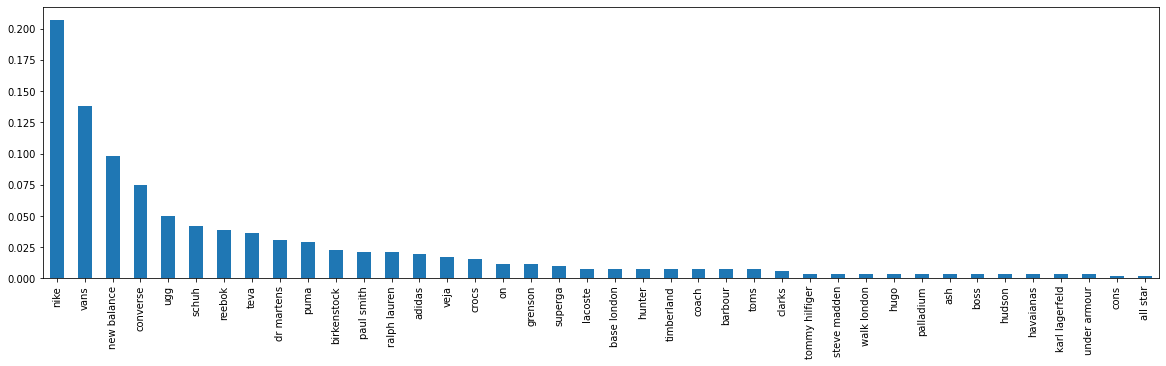

In [80]:
df.drop_duplicates("id").brand.value_counts(normalize=True).plot.bar(figsize=(20,5))

<AxesSubplot:>

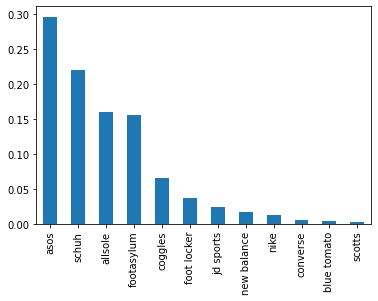

In [81]:
df.merchant.value_counts(normalize=True).plot.bar()

<AxesSubplot:>

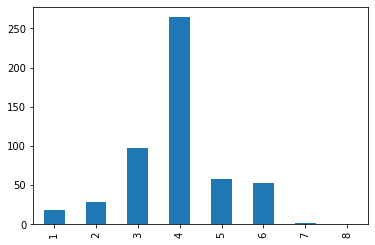

In [82]:
df.id.value_counts().value_counts().sort_index().plot.bar()

In [ ]:
df.to_csv("s3://aisle3-ml-datasets/arcface/image/test/aisle3_pose.csv", index=False)